# Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Project Content

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression


## Prepare the data

Import the mammographic_masses.data.txt file into a Pandas dataframe and take a look at it.
Convert missing data (indicated by a '?') into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity)

In [104]:
import numpy as np
import pandas as pd

df = pd.read_csv("mammographic_masses.data.txt",
                 names=['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity'],
                 na_values = '?')
print(df.head())

   BI-RADS   Age  Shape  Margin  Density  Severity
0      5.0  67.0    3.0     5.0      3.0         1
1      4.0  43.0    1.0     1.0      NaN         1
2      5.0  58.0    4.0     5.0      3.0         1
3      4.0  28.0    1.0     1.0      3.0         0
4      5.0  74.0    1.0     5.0      NaN         1


Evaluate whether the data needs cleaning; the model is only as good as the data it's given.

In [105]:
df.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

In [106]:
df.loc[(df['Age'].isnull()) |
       (df['Shape'].isnull()) |
       (df['Margin'].isnull()) |
       (df['Density'].isnull())].describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,129.000000,125.000000,99.000000,82.000000,54.000000,130.000000
mean,4.054264,53.560000,2.202020,2.609756,2.833333,0.323077
std,0.773689,13.087423,1.124675,1.561545,0.693637,0.469461
min,2.000000,23.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,43.000000,1.000000,1.000000,3.000000,0.000000
50%,4.000000,55.000000,2.000000,3.000000,3.000000,0.000000
75%,4.000000,63.000000,3.000000,4.000000,3.000000,1.000000
max,6.000000,82.000000,4.000000,5.000000,4.000000,1.000000


The missing data seems randomly distributed => drop rows with missing data.

In [115]:
df.dropna(inplace=True)
df.head()

,BI-RADS,Age,Shape,Margin,Density,Severity,agerange
0,5.0,67.0,3.0,5.0,3.0,1,4
2,5.0,58.0,4.0,5.0,3.0,1,3
3,4.0,28.0,1.0,1.0,3.0,0,0
8,5.0,57.0,1.0,5.0,3.0,1,3
10,5.0,76.0,1.0,4.0,3.0,1,4


Look at the evolution distribution of severity = 0 and severity = 1 with respect to age, and see if there are age groups that emerge.

[Text(0.5, 0, 'Population (hundreds of millions)'),
 Text(0, 0.5, 'Age'),
 Text(0.5, 1.0, 'Population Pyramid')]

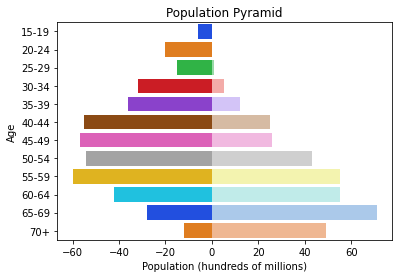

In [331]:
import matplotlib.pyplot as plt
import seaborn as sns

bins = [15 + 5*i for i in range(13)]
labels = ['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70+']

df['agerange'] = pd.cut(df.Age, bins, labels = labels,include_lowest = True)

severity_0 = df.loc[df['Severity']==0]['agerange'].value_counts()
severity_1 = df.loc[df['Severity']==1]['agerange'].value_counts()

bar_plot = sns.barplot(x=-severity_0, y=severity_0.index, orient='h', palette=sns.color_palette('bright'))

bar_plot = sns.barplot(x=severity_1, y=severity_1.index, orient='h', palette=sns.color_palette('pastel'))

bar_plot.set(xlabel="Population (hundreds of millions)", ylabel="Age", title = "Population Pyramid")

Age groups that seem to emerge are: 15-29, 30-39, 40-49, 50-64 and 65+

In [117]:
bins = [15, 30, 40, 50, 65, 85]
labels = [0, 1, 2, 3, 4]

df['agerange'] = pd.cut(df.Age, bins, labels = labels,include_lowest = True)
df.head()

,BI-RADS,Age,Shape,Margin,Density,Severity,agerange
0,5.0,67.0,3.0,5.0,3.0,1,4
2,5.0,58.0,4.0,5.0,3.0,1,3
3,4.0,28.0,1.0,1.0,3.0,0,0
8,5.0,57.0,1.0,5.0,3.0,1,3
10,5.0,76.0,1.0,4.0,3.0,1,4


Convert the Pandas dataframes into numpy arrays that can be used by scikit_learn.
Create an array that extracts only the feature data to work with (age, shape, margin, and density) and another array that contains the classes (severity).

In [118]:
features = ['agerange', 'Shape', 'Margin', 'Density']

X = np.array(df[features])
y = np.array(df['Severity'])

print(X.shape, y.size)

(817, 4) 817


Some of the models require the input data to be normalized.

In [120]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X = scale.fit_transform(X)

## Decision Trees

Create a single train/test split of our data: 75% for training, and 25% for testing.

In [121]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

Create a DecisionTreeClassifier and fit it to the training data.

In [122]:
from sklearn import tree

# myDecisionTree = tree.DecisionTreeClassifier()
myDecisionTree = tree.DecisionTreeClassifier().fit(X_train,y_train)

Display the resulting decision tree.

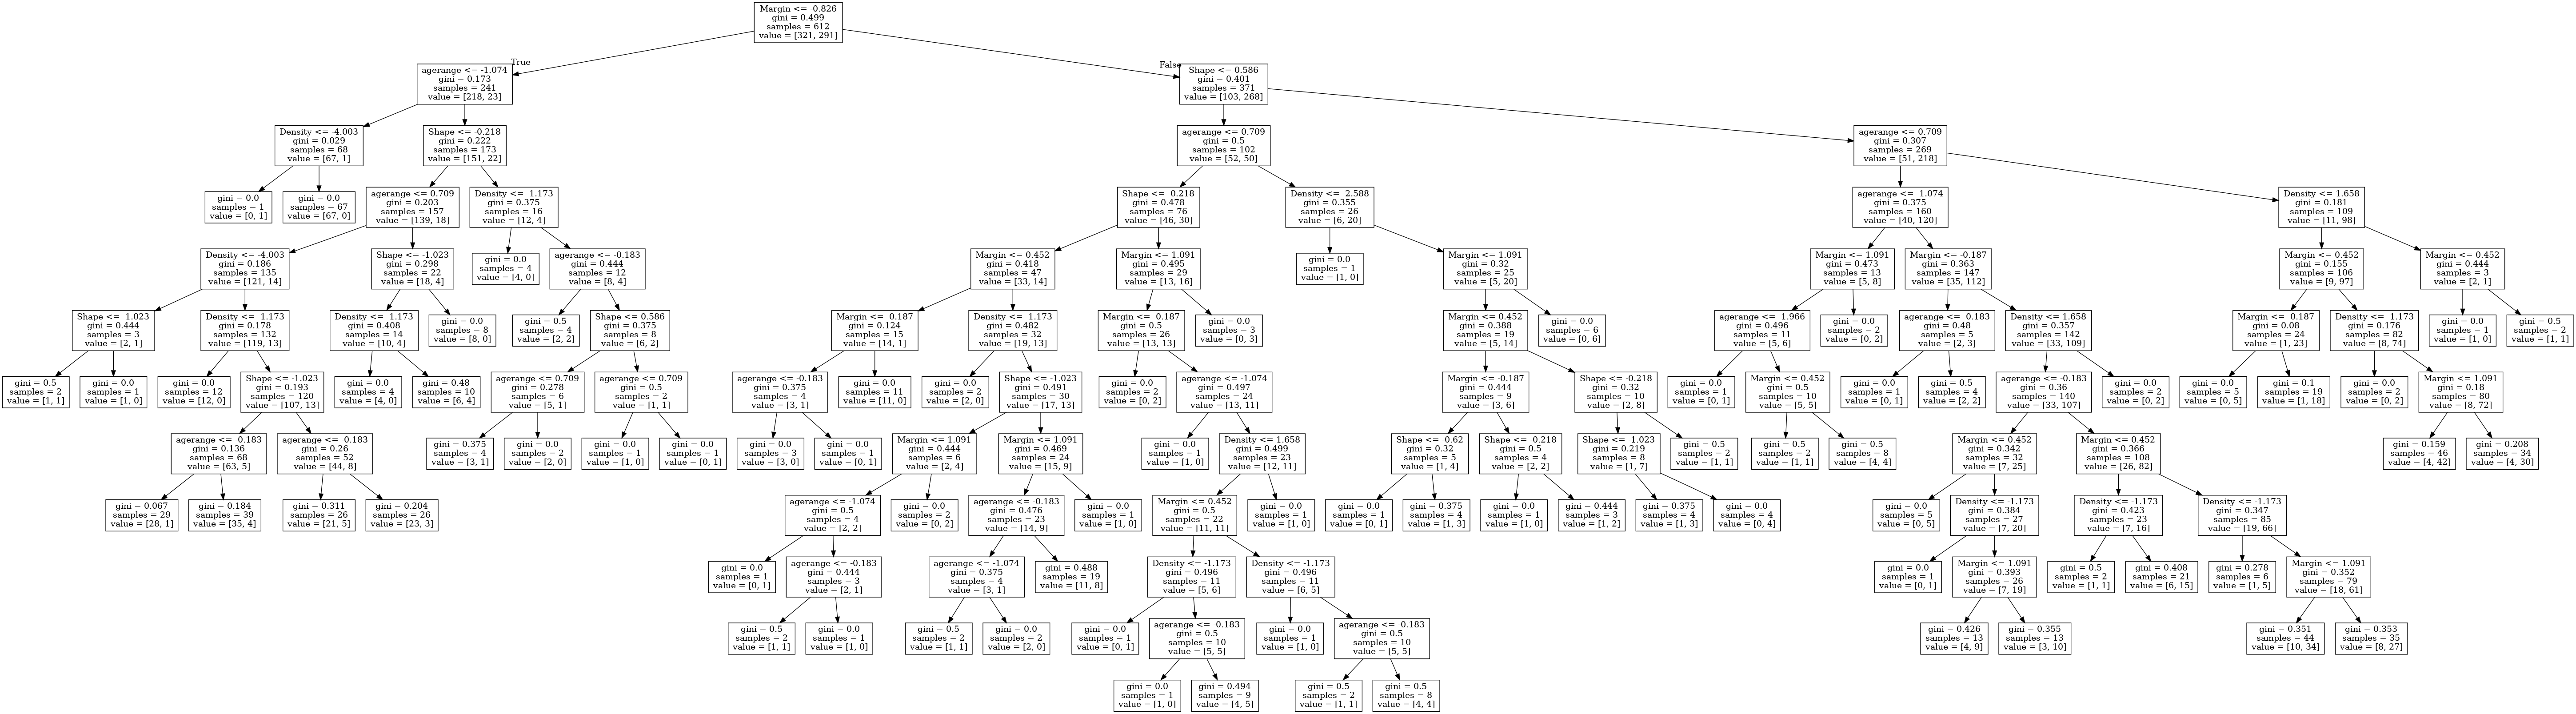

In [123]:
from IPython.display import Image  
from six import StringIO  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(
    myDecisionTree,
    out_file=dot_data,  
    feature_names=features
)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

Measure the accuracy of the resulting decision tree model using the test data.

In [124]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = clf.predict_proba(X_test)
print(y_pred)
# print(accuracy_score(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))

[[0.09302326 0.90697674]
 [0.29166667 0.70833333]
 [0.5        0.5       ]
 [0.15151515 0.84848485]
 [0.09302326 0.90697674]
 [1.         0.        ]
 [0.875      0.125     ]
 [1.         0.        ]
 [0.         1.        ]
 [0.29166667 0.70833333]
 [0.15789474 0.84210526]
 [0.58823529 0.41176471]
 [0.33333333 0.66666667]
 [0.875      0.125     ]
 [0.82608696 0.17391304]
 [0.09302326 0.90697674]
 [0.82608696 0.17391304]
 [0.25       0.75      ]
 [0.09302326 0.90697674]
 [0.47058824 0.52941176]
 [1.         0.        ]
 [0.95238095 0.04761905]
 [0.81818182 0.18181818]
 [0.25       0.75      ]
 [0.15151515 0.84848485]
 [0.29166667 0.70833333]
 [0.3        0.7       ]
 [0.09302326 0.90697674]
 [0.09302326 0.90697674]
 [0.875      0.125     ]
 [0.625      0.375     ]
 [0.09302326 0.90697674]
 [0.09302326 0.90697674]
 [1.         0.        ]
 [0.95238095 0.04761905]
 [0.95238095 0.04761905]
 [0.09302326 0.90697674]
 [0.09302326 0.90697674]
 [0.09302326 0.90697674]
 [1.         0.        ]


Instead of a single train/test split, we can use K-Fold cross validation to get a better measure of the model's accuracy (K=10).

In [125]:
from sklearn.model_selection import cross_val_score

# We give cross_val_score a model, the entire data set and its "real" values, and the number of folds:
scores = cross_val_score(clf, X, y, cv=10)

# And the mean accuracy of all 10 folds:
print(scores.mean())

0.7809545317675399


Now try a RandomForestClassifier instead. Does it perform better?

In [126]:
from sklearn.ensemble import RandomForestClassifier

myRandomForestClassifier = RandomForestClassifier(n_estimators=10)
myRandomForestClassifier = myRandomForestClassifier.fit(X_train, y_train)

scores = cross_val_score(myRandomForestClassifier, X, y, cv=10)
print(scores.mean())

0.7711683227943391


The score difference is not significant.

## SVM

Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [127]:
from sklearn import svm

mySVM = svm.SVC().fit(X_train, y_train)

scores = cross_val_score(mySVM, X, y, cv=10)
print(scores.mean())

0.790695573622403


The cross validation score is slightly better

## KNN
How about K-Nearest-Neighbors? Let's start with a K of 10. K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set.

In [128]:
from sklearn.neighbors import KNeighborsClassifier

myKNeighborsClassifier = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)
scores = cross_val_score(myKNeighborsClassifier, X, y, cv=10)
print(scores.mean())

0.7625564588979223


Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference.

0.7955736224028906


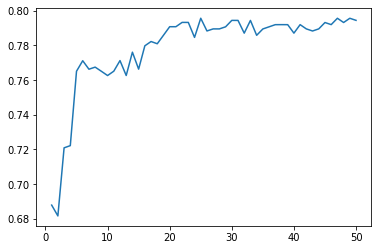

In [129]:
from seaborn import lineplot
from pandas import DataFrame

accuracies = []

for n_neighbors in range(1, 51):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = cross_val_score(clf, X, y, cv=10).mean()
    accuracies.append(accuracy)


lineplot(x = list(range(1, 51)), y = accuracies)
print(max(accuracies))

The best performance got out of KNN is 0.795

## Naive Bayes

Try naive_bayes.MultinomialNB. How does its accuracy stack up?

In [130]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB

scale = MinMaxScaler()
X = scale.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y)

myMultinomialNB = MultinomialNB().fit(X_train, y_train)

scores = cross_val_score(myMultinomialNB, X, y, cv=10)
print(scores.mean())

0.7773110508882866


## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Try the rbf, sigmoid, and poly kernels and see what the best-performing kernel is. Do we have a new winner?

In [131]:
mySVM_linear = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

scores = cross_val_score(mySVM_linear, X, y, cv=10)
print(scores.mean())

0.7907256850346281


In [132]:
mySVM_sigmoid = svm.SVC(kernel='sigmoid').fit(X_train, y_train)

scores = cross_val_score(mySVM_sigmoid, X, y, cv=10)
print(scores.mean())

0.29143330322192107


## Logistic Regression

We've tried all these fancy techniques, but fundamentally this is just a binary classification problem. Try Logisitic Regression, which is a simple way to tackling this sort of thing.

In [133]:
from sklearn.linear_model import LogisticRegression

myLogisticRegression = LogisticRegression().fit(X_train, y_train)

#scores = cross_val_score(clf, X, y, cv=10)
#print(scores.mean())

print(myLogisticRegression.predict_proba([[23, 5, 4, 5], [46, 5, 4, 5], [57, 5, 4, 5], [67, 3, 4, 3]]))

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


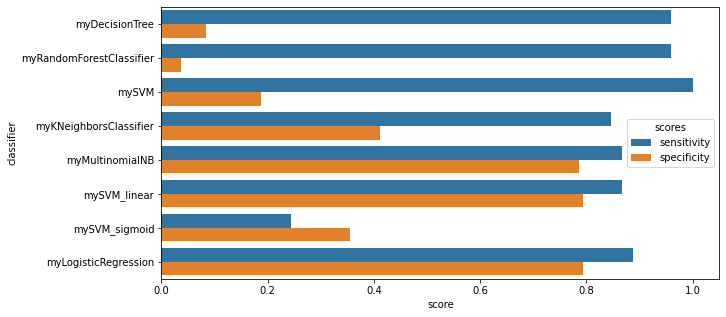

In [347]:
def my_score(conf_matrix):
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    sensitivity = TP / (FN + TP)
    specificity = TN / (TN + FP)
    return sensitivity, specificity

# str(myLogisticRegression)
classifiers = [
    myDecisionTree,
    myRandomForestClassifier,
    mySVM,
    myKNeighborsClassifier,
    myMultinomialNB,
    mySVM_linear,
    mySVM_sigmoid,
    myLogisticRegression,
]

classifiers_str = [
    'myDecisionTree',
    'myRandomForestClassifier',
    'mySVM',
    'myKNeighborsClassifier',
    'myMultinomialNB',
    'mySVM_linear',
    'mySVM_sigmoid',
    'myLogisticRegression',
]

scores = {}

for i, clf in enumerate(classifiers):
    y_pred = clf.predict(X_test)
    matrix = confusion_matrix(y_test, y_pred)
    sensitivity, specificity = my_score(matrix)
    scores[2*i] = [classifiers_str[i], 'sensitivity', sensitivity]
    scores[2*i+1] = [classifiers_str[i], 'specificity', specificity]
    
score_data = pd.DataFrame.from_dict(data=scores, orient='index', columns=['classifier', 'scores', 'score'])

plt.figure(figsize=(10,5))
ax = sns.barplot(y='classifier', x='score', hue='scores',data=score_data)


## Do we have a winner?


The best performing technique for this data is the Logistic Regression with a cross  validation score of 80%